In [1]:
from __future__ import print_function, division

# Ignore warnings
import warnings

import torch
from morpho_common import setup_common_args

warnings.filterwarnings("ignore")

import importlib
import morpho_data_loaders
import morpho_model

importlib.reload(morpho_data_loaders)
importlib.reload(morpho_model)

import youtokentome as yttm
from morpho_data_loaders import KBVocab, AffixSetVocab
from morpho_model import kinyabert_base

home_path = "/mnt/NVM/KINLP/"
USE_GPU = False

device = torch.device('cpu')
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device: ', device, flush=True)

BPE_model_path = (home_path + "data/BPE-30k.mdl")
bpe_encoder = yttm.BPE(model=BPE_model_path)

kb_vocab = KBVocab()
kbvocab_state_dict_file_path = (home_path + "data/kb_vocab_state_dict_2021-02-07.pt")
kb_vocab.load_state_dict(torch.load(kbvocab_state_dict_file_path))

from fairseq.models.roberta import RobertaModel
from fairseq.data.encoders import register_bpe

@register_bpe("nonebpe")
class NoneBPE(object):

    @staticmethod
    def add_args(parser):
        pass

    def __init__(self, args):
        pass

    def encode(self, x: str) -> str:
        return x

    def decode(self, x: str) -> str:
        return x

def get_kinyabert_model_pos_embedding(args):
    from torch.nn.parallel import DistributedDataParallel as DDP

    affix_set_vocab = AffixSetVocab(
        reduced_affix_dict_file=home_path + "data/reduced_affix_dict_" + str(args.afset_dict_size) + ".csv",
        reduced_affix_dict_map_file=home_path + "data/reduced_affix_dict_map_" + str(args.afset_dict_size) + ".csv")

    args.world_size = args.gpus
    args.num_pos_m_embeddings = args.pos
    args.num_stem_m_embeddings = args.stem
    args.use_affix_bow_m_embedding = args.use_affix_bow
    args.use_pos_aware_rel_pos_bias = args.use_pos_aware_rel
    args.use_tupe_rel_pos_bias = args.use_tupe_rel
    args.num_inference_iters = args.inference_iters
    args.num_inference_runs = args.inference_runs

    morpho_rel_pos_dict = None
    morpho_rel_pos_dmax = 5
    if args.use_pos_aware_rel_pos_bias:
        morpho_rel_pos_dict_file_path = (home_path+"data/morpho_rel_pos_dict_2021-03-24.pt")
        saved_pos_rel_dict = torch.load(morpho_rel_pos_dict_file_path)
        morpho_rel_pos_dict = saved_pos_rel_dict['morpho_rel_pos_dict']
        morpho_rel_pos_dmax = saved_pos_rel_dict['morpho_rel_pos_dmax']

    kb_model = kinyabert_base(kb_vocab, affix_set_vocab, morpho_rel_pos_dict,
                           device, args, saved_model_file=None)
    ddp_model = DDP(kb_model)

    args.num_inference_runs = 10
    kb_state_dict = torch.load(args.inference_model_file, map_location=device)
    ddp_model.load_state_dict(kb_state_dict['model_state_dict'])
    kb_model = ddp_model.module
    kb_model.eval()

    return kb_model.encoder.get_position_attn_bias(None, 128, 1, device) # Shape: (12, 128, 128)

def get_roberta_model_pos_embedding(args):
    if args.xlmr:
        from fairseq.models.roberta import XLMRModel
        roberta = XLMRModel.from_pretrained(args.pretrained_roberta_model_dir, checkpoint_file=args.pretrained_roberta_checkpoint_file, bpe="nonebpe")
    else:
        roberta = RobertaModel.from_pretrained(args.pretrained_roberta_model_dir, checkpoint_file=args.pretrained_roberta_checkpoint_file, bpe="nonebpe")

    sentence_encoder = roberta.model.decoder.sentence_encoder
    sentence_encoder.eval()

    return sentence_encoder.get_position_attn_bias(128, 1, device) # Shape: (12, 128, 128)

def plot_positional_corr(pos_tensor, title):
    import matplotlib
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import AxesGrid

    font = {'family': 'normal',
            'size': 18}

    matplotlib.rc('font', **font)

    t = pos_tensor.detach().numpy()
    vals = [pos_tensor[0, :, :].detach().numpy(),
            pos_tensor[1, :, :].detach().numpy(),
            pos_tensor[2, :, :].detach().numpy(),
            pos_tensor[3, :, :].detach().numpy(),
            pos_tensor[4, :, :].detach().numpy(),
            pos_tensor[5, :, :].detach().numpy(),
            pos_tensor[6, :, :].detach().numpy(),
            pos_tensor[7, :, :].detach().numpy(),
            pos_tensor[8, :, :].detach().numpy(),
            pos_tensor[9, :, :].detach().numpy(),
            pos_tensor[10, :, :].detach().numpy(),
            pos_tensor[11, :, :].detach().numpy()]

    m = t.mean()
    s = t.std()

    vals = [((v-m)/s) for v in vals]

    fig = plt.figure()

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(2, 6),
                    axes_pad=0.05,
                    share_all=True,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="single",
                    )

    for val, ax in zip(vals,grid):
        im = ax.imshow(val, vmin=-1, vmax=1)

    grid.cbar_axes[0].colorbar(im, ticks = [-1.0, -0.5, 0.0, 0.5, 1.0])

    plt.title(title)
    plt.show()


import os
import torch.distributed as dist

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '88599'
dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

Using device:  cpu


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


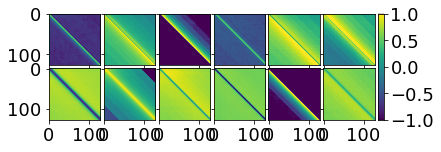

In [2]:
args = setup_common_args(silent=True)
args.model_keyword = 'kinyabert-tupe-36K'
args.gpus = 0
args.pos = 3
args.stem = 1
args.use_affix_bow = False
args.use_pos_aware_rel = False
args.use_tupe_rel = True
args.use_afsets = False
args.predict_affixes = True
args.inference_model_file = '/mnt/NVM/KinyaBERT_Checkpoints/kb_attentive/morpho_attentive_model_base_2021-07-12.pt'

kinyabert_adr_pos_tensor = get_kinyabert_model_pos_embedding(args)

plot_positional_corr(kinyabert_adr_pos_tensor, 'KinyaBERT_ADR')

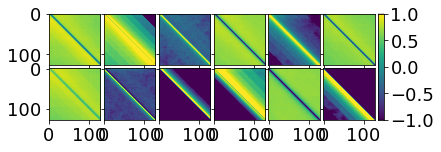

In [3]:
args = setup_common_args(silent=True)
args.model_keyword = 'kinyabert-afset-38K'
args.gpus = 0
args.pos = 2
args.stem = 1
args.use_affix_bow = False
args.use_pos_aware_rel = False
args.use_tupe_rel = True
args.use_afsets = True
args.predict_affixes = False
args.afset_dict_size = 34008
args.inference_model_file = '/mnt/NVM/KinyaBERT_Checkpoints/kb_attentive/exploratory_kinyabert_model_2021-08-29_pos@2_stem@1_mbow@False_pawrel@False_tuperel@True_afsets@True@34008_predaffixes@False.pt'

kinyabert_asc_pos_tensor = get_kinyabert_model_pos_embedding(args)

plot_positional_corr(kinyabert_asc_pos_tensor, 'KinyaBERT_ASC')

loading archive file /mnt/NVM/KinyaBERT_Checkpoints/checkpoints-roberta-tupe-bpe-tpu/
| dictionary: 42616 types


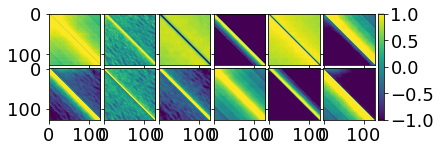

In [4]:
args = setup_common_args(silent=True)
args.model_keyword = 'roberta-bpe-32K'
args.input_format = 'bpe'
args.pretrained_roberta_model_dir = '/mnt/NVM/KinyaBERT_Checkpoints/checkpoints-roberta-tupe-bpe-tpu/'
args.pretrained_roberta_checkpoint_file = 'checkpoint_94_31920.pt'

roberta_bpe_pos_tensor = get_roberta_model_pos_embedding(args)

plot_positional_corr(roberta_bpe_pos_tensor, 'BERT_BPE')

loading archive file /mnt/NVM/KinyaBERT_Checkpoints/checkpoints-roberta-tupe-30morpho-tpu/
| dictionary: 50984 types


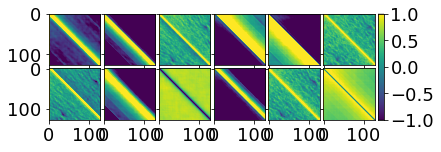

In [5]:
args = setup_common_args(silent=True)
args.model_keyword = 'roberta-30morpho-32K'
args.input_format = 'morpho'
args.pretrained_roberta_model_dir = '/mnt/NVM/KinyaBERT_Checkpoints/checkpoints-roberta-tupe-30morpho-tpu/'
args.pretrained_roberta_checkpoint_file = 'checkpoint_44_31920.pt'

roberta_morpho_pos_tensor = get_roberta_model_pos_embedding(args)

plot_positional_corr(roberta_morpho_pos_tensor, 'BERT_MORPHO')